In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [2]:
geo = "GSE61741"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Keller2014", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [3]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [4]:
"hsa-miR-155" in list(mirnas)

True

In [5]:
table

,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,843,844,845,846,847
VALUE,5.653241,37.688751,29.893947,523.693279,72.091277,102.182793,122.950191,10.667541,1.000000,1232.595567,...,54.531697,1.000000,5515.939466,1.000000,45.783842,68.556959,54.531697,15.398713,341.261916,6069.108437
VALUE,1.000000,36.127979,42.218303,1015.585081,109.778599,149.095567,137.578408,4.984986,1.000000,2141.470686,...,53.509295,1.000000,1781.658484,1.000000,67.633699,92.819113,36.127979,16.551239,98.982126,4980.898951
VALUE,1.838179,43.823880,48.048856,1635.165157,148.378694,106.990705,148.378694,1.838179,1.000000,1506.186845,...,43.823880,1.000000,2990.154194,1.000000,75.206625,71.230934,40.182316,1.000000,75.206625,4980.898951
VALUE,17.422545,6.007865,54.870591,865.701859,100.727121,131.789323,218.082221,6.007865,1.000000,3306.918494,...,80.532412,1.000000,2782.872736,1.000000,110.959247,28.147045,54.870591,28.147045,100.727121,7052.158484
VALUE,64.709009,42.723785,31.321497,790.820424,18.199476,117.466873,84.659914,18.199476,18.199476,1745.642993,...,53.989275,1.000000,1395.469018,4.051716,64.709009,105.053146,117.466873,18.199476,105.053146,8272.852002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,10.976883,10.976883,17.867493,134.089371,33.181363,17.867493,40.641802,17.867493,1.000000,1172.177550,...,48.462583,17.867493,7834.984509,25.538847,202.371306,25.538847,17.867493,1.000000,40.641802,6712.010010
VALUE,36.375834,20.227121,36.375834,661.283365,166.475453,54.621068,72.956387,1.000000,1.000000,1709.627502,...,64.472116,1.000000,6712.010010,20.227121,81.925882,64.472116,119.018828,36.375834,81.925882,7834.984509
VALUE,50.838179,60.602240,42.637989,333.212583,42.637989,123.882269,66.998808,34.141802,10.122259,842.527645,...,26.229504,14.381792,7634.697569,50.838179,102.920400,42.637989,50.838179,26.229504,94.307197,6712.010010
VALUE,82.895853,52.344376,82.895853,344.241897,1.000000,318.279075,36.619876,1.000000,1.000000,820.607007,...,82.895853,45.089847,5780.195901,1.000000,52.344376,45.089847,52.344376,5.790515,102.920400,7434.410629


### Seperate case and controls

In [6]:
list(data.gsms.values())[0].metadata

{'title': ['sample1'],
 'geo_accession': ['GSM1512138'],
 'status': ['Public on Dec 31 2014'],
 'submission_date': ['Sep 25 2014'],
 'last_update_date': ['Dec 31 2014'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['RNA from blood'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['disease: lung cancer'],
 'treatment_protocol_ch1': ['stored at -20 degree'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['Blood of controls and patients was extracted in PAXgene Blood RNA tubes (BD, Franklin Lakes, New Jersey USA). The content of blood sampling tubes of each patient and healthy donor was used for RNAe extraction. The total RNA including the miRNA was isolated using the miRNeasy kit (Qiagen GmbH, Hilden) according to manufacturers instructions..'],
 'label_ch1': ['biotin'],
 'label_protocol_ch1': ['MPEA, microfluidic primer extension assay Biotin labeling'],
 'hyb_protocol': ['according to manufacturers instruction (febit bi

In [7]:
set([k.metadata["characteristics_ch1"][0] for k in list(data.gsms.values())])

{'disease: Periodontitis',
 'disease: Renal cancer',
 'disease: Wilms Tumor',
 'disease: benign prostate hyperplasia',
 'disease: chronic obstructive pulmonary disease (COPD)',
 'disease: colon cancer',
 'disease: ductal adenocarcinoma',
 'disease: glioma',
 'disease: long-lived individuals',
 'disease: lung cancer',
 'disease: melanoma',
 'disease: multiple sclerosis',
 'disease: myocardial_infarction',
 'disease: non-ischaemic systolic heart failure',
 'disease: normal',
 'disease: others',
 'disease: ovarian cancer',
 'disease: pancreatitis',
 'disease: prostate cancer',
 'disease: psoriasis',
 'disease: sarcoidosis',
 'disease: tumor of stomach'}

In [8]:
sick = np.array(["lung cancer" in k.metadata["characteristics_ch1"][0] for k in list(data.gsms.values())])
controls = np.array(["normal" in k.metadata["characteristics_ch1"][0] for k in list(data.gsms.values())])
mask = sick + controls
sick = sick[mask]
controls = controls[mask]
table = table[mask]

In [9]:
sum(sick)

73

### Drop NAN

In [10]:
table.std().min()

16.373507764093777

In [11]:
table = table.fillna(table.min().min())

### T-test

In [12]:
X = table

In [13]:
X

,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,843,844,845,846,847
VALUE,5.653241,37.688751,29.893947,523.693279,72.091277,102.182793,122.950191,10.667541,1.000000,1232.595567,...,54.531697,1.000000,5515.939466,1.000000,45.783842,68.556959,54.531697,15.398713,341.261916,6069.108437
VALUE,1.000000,36.127979,42.218303,1015.585081,109.778599,149.095567,137.578408,4.984986,1.000000,2141.470686,...,53.509295,1.000000,1781.658484,1.000000,67.633699,92.819113,36.127979,16.551239,98.982126,4980.898951
VALUE,1.838179,43.823880,48.048856,1635.165157,148.378694,106.990705,148.378694,1.838179,1.000000,1506.186845,...,43.823880,1.000000,2990.154194,1.000000,75.206625,71.230934,40.182316,1.000000,75.206625,4980.898951
VALUE,17.422545,6.007865,54.870591,865.701859,100.727121,131.789323,218.082221,6.007865,1.000000,3306.918494,...,80.532412,1.000000,2782.872736,1.000000,110.959247,28.147045,54.870591,28.147045,100.727121,7052.158484
VALUE,64.709009,42.723785,31.321497,790.820424,18.199476,117.466873,84.659914,18.199476,18.199476,1745.642993,...,53.989275,1.000000,1395.469018,4.051716,64.709009,105.053146,117.466873,18.199476,105.053146,8272.852002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,45.089847,1.000000,22.503575,199.890610,22.503575,34.901096,80.400620,1.000000,22.503575,618.217588,...,67.751907,22.503575,8761.700429,1.000000,122.460677,1.000000,122.460677,108.397760,56.125596,5780.195901
VALUE,55.484986,1.000000,45.566492,134.953050,97.628932,55.484986,6.351049,97.628932,35.072688,1296.829600,...,55.484986,1.000000,8761.700429,6.351049,25.077455,75.357483,97.628932,55.484986,349.923022,5515.939466
VALUE,10.667541,1.000000,33.352955,151.238322,22.111773,51.053623,87.456864,33.352955,22.111773,1395.469018,...,33.352955,10.667541,10571.609870,22.111773,87.456864,140.040277,33.352955,10.667541,297.398713,6712.010010
VALUE,2.148951,1.000000,50.605577,107.814347,1.000000,39.059342,26.561249,61.792421,26.561249,1823.352479,...,50.605577,1.000000,9920.790038,26.561249,86.289800,74.868208,126.515253,2.148951,333.212583,6377.970210


In [14]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [15]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [16]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [17]:
mirnas.iloc[lowest], pvalues

(125        hsa-miR-17
 443       hsa-miR-107
 292       hsa-miR-126
 230      hsa-miR-144*
 639    hsa-miR-331-3p
 Name: ID_REF, dtype: object,
 array([1.22002438e-13, 1.54130501e-13, 3.35725702e-12, 4.28770542e-12,
        9.35686823e-12]))

### F-test

In [18]:
t3 = table

In [19]:
f, p = f_classif(t3, sick)

In [20]:
np.mean(p)

0.22185169091690032

### ANOVA

In [21]:
t3

,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,843,844,845,846,847
VALUE,5.653241,37.688751,29.893947,523.693279,72.091277,102.182793,122.950191,10.667541,1.000000,1232.595567,...,54.531697,1.000000,5515.939466,1.000000,45.783842,68.556959,54.531697,15.398713,341.261916,6069.108437
VALUE,1.000000,36.127979,42.218303,1015.585081,109.778599,149.095567,137.578408,4.984986,1.000000,2141.470686,...,53.509295,1.000000,1781.658484,1.000000,67.633699,92.819113,36.127979,16.551239,98.982126,4980.898951
VALUE,1.838179,43.823880,48.048856,1635.165157,148.378694,106.990705,148.378694,1.838179,1.000000,1506.186845,...,43.823880,1.000000,2990.154194,1.000000,75.206625,71.230934,40.182316,1.000000,75.206625,4980.898951
VALUE,17.422545,6.007865,54.870591,865.701859,100.727121,131.789323,218.082221,6.007865,1.000000,3306.918494,...,80.532412,1.000000,2782.872736,1.000000,110.959247,28.147045,54.870591,28.147045,100.727121,7052.158484
VALUE,64.709009,42.723785,31.321497,790.820424,18.199476,117.466873,84.659914,18.199476,18.199476,1745.642993,...,53.989275,1.000000,1395.469018,4.051716,64.709009,105.053146,117.466873,18.199476,105.053146,8272.852002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,45.089847,1.000000,22.503575,199.890610,22.503575,34.901096,80.400620,1.000000,22.503575,618.217588,...,67.751907,22.503575,8761.700429,1.000000,122.460677,1.000000,122.460677,108.397760,56.125596,5780.195901
VALUE,55.484986,1.000000,45.566492,134.953050,97.628932,55.484986,6.351049,97.628932,35.072688,1296.829600,...,55.484986,1.000000,8761.700429,6.351049,25.077455,75.357483,97.628932,55.484986,349.923022,5515.939466
VALUE,10.667541,1.000000,33.352955,151.238322,22.111773,51.053623,87.456864,33.352955,22.111773,1395.469018,...,33.352955,10.667541,10571.609870,22.111773,87.456864,140.040277,33.352955,10.667541,297.398713,6712.010010
VALUE,2.148951,1.000000,50.605577,107.814347,1.000000,39.059342,26.561249,61.792421,26.561249,1823.352479,...,50.605577,1.000000,9920.790038,26.561249,86.289800,74.868208,126.515253,2.148951,333.212583,6377.970210


In [22]:
X = np.array(sick).reshape(-1, 1)

In [23]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [24]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.038280627013380406

### Mean-variance-plot

In [25]:
np.mean(table)

0        52.184020
1        48.749575
2        41.056154
3       373.364266
4        98.791599
          ...     
843      51.995349
844      47.498520
845      28.066831
846     186.806267
847    7488.494036
Length: 848, dtype: float64

In [26]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [27]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

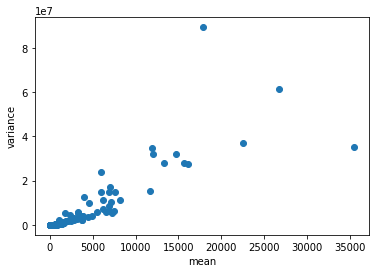

In [28]:
mean_variance_plot(table)

### Log transformation

In [29]:
log_table = table #np.log2(table)

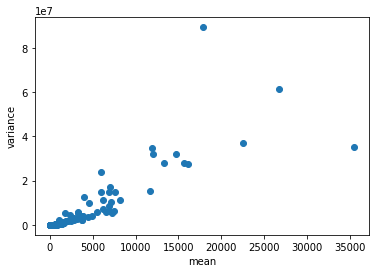

In [30]:
mean_variance_plot(log_table)

### Loess regression

In [31]:
lowess = LowessRegression(sigma=1, span=0.1)

In [32]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [33]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

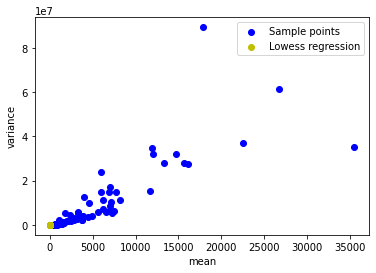

In [34]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [35]:
norm_log_table = log_table# - np.mean(log_table)

In [36]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

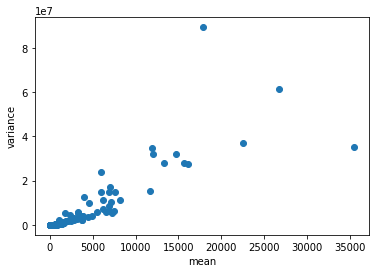

In [37]:
mean_variance_plot(norm_log_table)

### PCA

In [38]:
pca = decomposition.PCA(n_components=10)

In [39]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [40]:
pca.explained_variance_ratio_

array([0.22471831, 0.12751132, 0.10839095, 0.08488631, 0.0702827 ,
       0.06217679, 0.04444318, 0.0359082 , 0.0275527 , 0.0238391 ])

In [41]:
components = pca.transform(norm_log_table)

In [42]:
components.shape

(167, 10)

In [43]:
sum(controls)

94

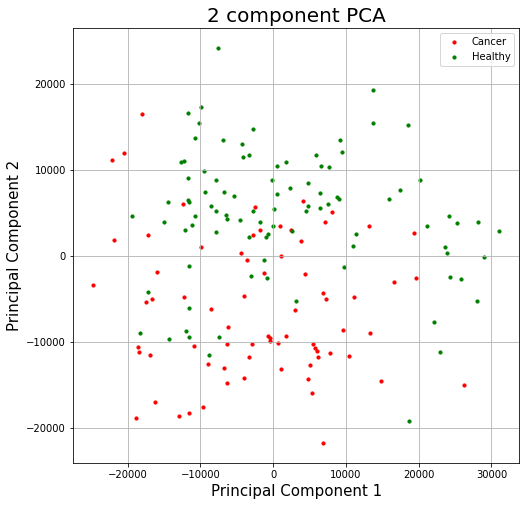

In [44]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [45]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

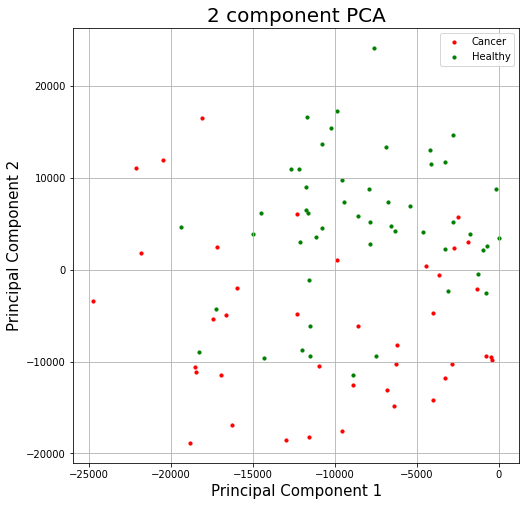

In [46]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [47]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [48]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


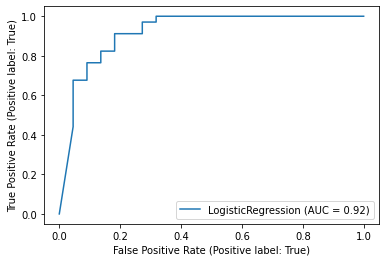

In [49]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [50]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[18:30:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


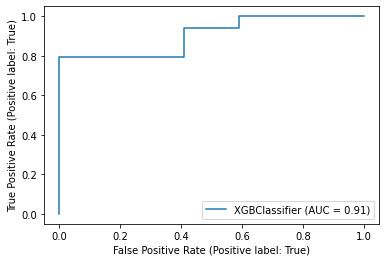

In [51]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [52]:
lookup_table = data.gpls["GPL9040"].table

In [53]:
lookup_table = lookup_table.set_index("ID")

In [54]:
"hsa-miR-155" in list(mirnas)

True

In [55]:
lookup_table.loc["hsa-miR-155"]

SEQUENCE    uuaaugcuaaucgugauaggggu
miRNA_ID                hsa-miR-155
Name: hsa-miR-155, dtype: object

In [56]:
sequences = lookup_table.loc[mirnas]["SEQUENCE"]

In [57]:
sequences = [s.upper() for s in sequences]

In [58]:
sequences[:10]

['ACUCAAAACCCUUCAGUGACUU',
 'UUAGGGCCCUGGCUCCAUCUCC',
 'AACAAUAUCCUGGUGCUGAGUG',
 'CUCAUCUGCAAAGAAGUAAGUG',
 'UCAGCAAACAUUUAUUGUGUGC',
 'CAAACCACACUGUGGUGUUAGA',
 'AACAUCACAGCAAGUCUGUGCU',
 'AUCCUUGCUAUCUGGGUGCUA',
 'UAGGUUAUCCGUGUUGCCUUCG',
 'AAUGGCGCCACUAGGGUUGUG']

In [59]:
#norm_log_table *= -1

In [60]:
norm_log_table.columns = sequences
norm_log_table = norm_log_table.loc[:,~norm_log_table.columns.duplicated()]
norm_log_table["cancer"] = sick

C:\Users\olefr\AppData\Local\Temp/ipykernel_1188/4293022894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_log_table["cancer"] = sick


In [61]:
norm_log_table.head()

,ACUCAAAACCCUUCAGUGACUU,UUAGGGCCCUGGCUCCAUCUCC,AACAAUAUCCUGGUGCUGAGUG,CUCAUCUGCAAAGAAGUAAGUG,UCAGCAAACAUUUAUUGUGUGC,CAAACCACACUGUGGUGUUAGA,AACAUCACAGCAAGUCUGUGCU,AUCCUUGCUAUCUGGGUGCUA,UAGGUUAUCCGUGUUGCCUUCG,AAUGGCGCCACUAGGGUUGUG,...,AAGUAGUUGGUUUGUAUGAGAUGGUU,CUGACCUAUGAAUUGACAGCC,UAAGUGCUUCCAUGUUUGAGUGU,UACCCUGUAGAACCGAAUUUGUG,AAGCCCUUACCCCAAAAAGUAU,UGAGUGCCGGUGCCUGCCCUG,CAGGUCGUCUUGCAGGGCUUCU,ACUGGACUUAGGGUCAGAAGGC,AAGCUGCCAGUUGAAGAACUGU,cancer
VALUE,5.653241,37.688751,29.893947,523.693279,72.091277,102.182793,122.950191,10.667541,1.000000,1232.595567,...,1.0,5515.939466,1.000000,45.783842,68.556959,54.531697,15.398713,341.261916,6069.108437,True
VALUE,1.000000,36.127979,42.218303,1015.585081,109.778599,149.095567,137.578408,4.984986,1.000000,2141.470686,...,1.0,1781.658484,1.000000,67.633699,92.819113,36.127979,16.551239,98.982126,4980.898951,True
VALUE,1.838179,43.823880,48.048856,1635.165157,148.378694,106.990705,148.378694,1.838179,1.000000,1506.186845,...,1.0,2990.154194,1.000000,75.206625,71.230934,40.182316,1.000000,75.206625,4980.898951,True
VALUE,17.422545,6.007865,54.870591,865.701859,100.727121,131.789323,218.082221,6.007865,1.000000,3306.918494,...,1.0,2782.872736,1.000000,110.959247,28.147045,54.870591,28.147045,100.727121,7052.158484,True
VALUE,64.709009,42.723785,31.321497,790.820424,18.199476,117.466873,84.659914,18.199476,18.199476,1745.642993,...,1.0,1395.469018,4.051716,64.709009,105.053146,117.466873,18.199476,105.053146,8272.852002,False


In [62]:
norm_log_table.to_csv("../TransformedData/Keller2014_raw.csv", index=False)